# Data Exploration
This script is used to explore the functional connectivities using a variety of unsupervised machine learning models.

## Read Data

In [1]:
import glob
import numpy as np
from nilearn import plotting, image, datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Search for all functional connectivity files and read them into a
# numpy array.
fc_path = '/imaging3/owenlab/bpho/python_power_fc'
fc_paths = glob.glob(fc_path + '/**/power_fc.npy', recursive=True)

fcs = []
for path in fc_paths:
    fcs.append(np.load(path))
fcs = np.array(fcs)
print(fcs.shape)

(722, 264, 264)


## Preprocess FC

In [3]:
# Preprocess the functional connectivy by only taking the upper
# triange of the matrix (since FC is mirrored across diagonal).
# Ignore the diagonal (k=1) since it contains no useful info.
fcs_trius = []

for fc in fcs:
    fc_triu = fc[np.triu_indices(264, k=1)]
    fcs_trius.append(fc_triu)

fcs_trius = np.array(fcs_trius)
# The shape should be (num_samples, 34716).
# 264 x 264 = 69,696 / 2 = 34,848 - (264/2) = 34,716
print(fcs_trius.shape)

(722, 34716)


## Train and Analyze Signal Decomposition Models

### Principle Component Analysis (PCA)

In [4]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(fcs_trius)
fcs_trius_pca_reduced = pca.transform(fcs_trius)

print(pca.explained_variance_ratio_[0:3])
print(pca.components_.shape)

[0.20401968 0.03394974 0.02829019]
(722, 34716)


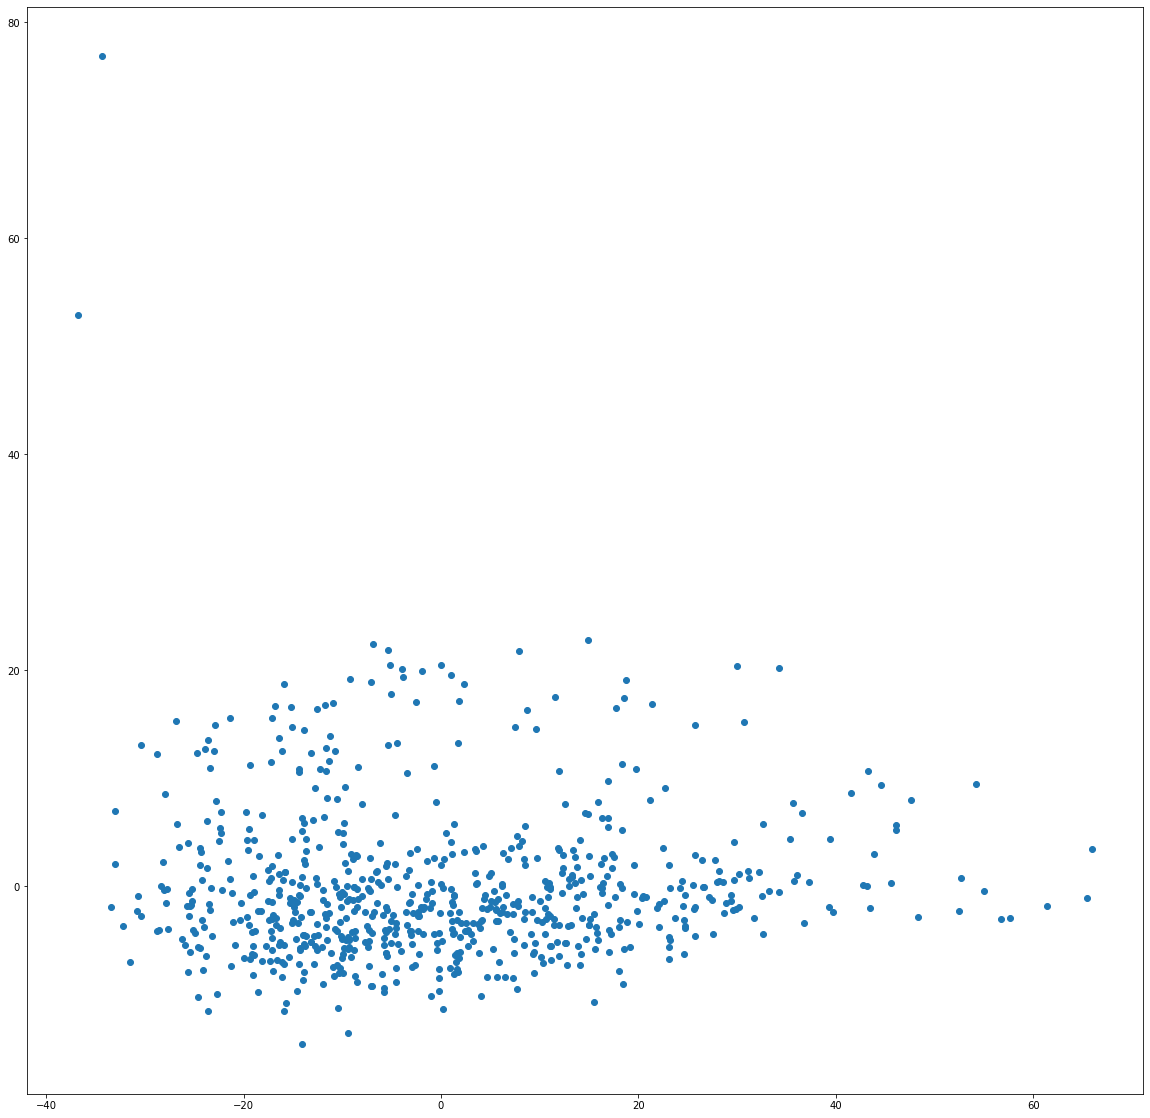

In [5]:
# Plot 2D dimensionality reduction
plt.figure(figsize=(20, 20))
plt.scatter(fcs_trius_pca_reduced[:, 0], fcs_trius_pca_reduced[:, 1])
plt.show()

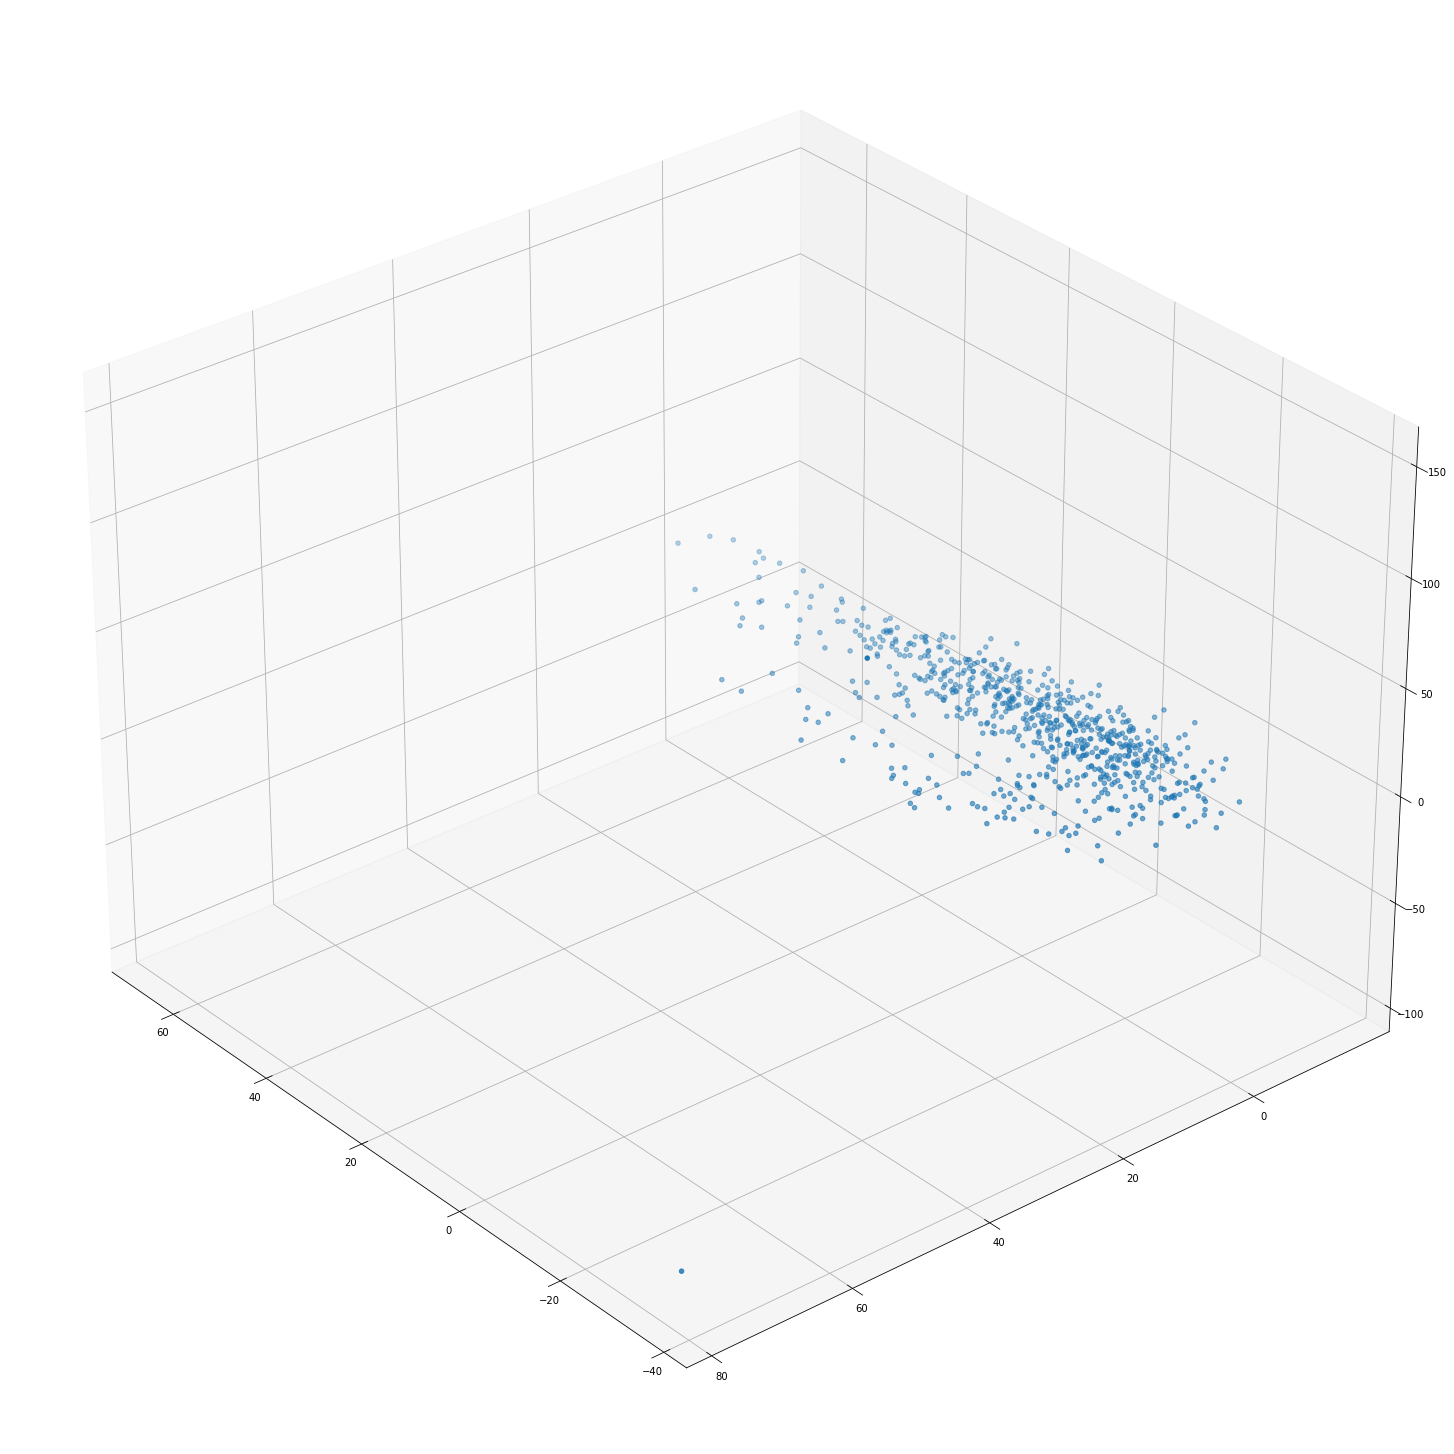

In [6]:
# Plot 3D dimensionality reduction
fig = plt.figure(figsize=(20, 20))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=140)
plt.cla()
ax.scatter(fcs_trius_pca_reduced[:, 0], fcs_trius_pca_reduced[:, 1], 
           fcs_trius_pca_reduced[:, 2])
plt.show()

In [7]:
# Reconstruct the FC but with the first PCA component.

first_pca_component = pca.components_[0]

fc_pca = np.zeros((264, 264))
fc_pca[np.triu_indices(fc_pca.shape[0], k=1)] = first_pca_component
fc_pca = fc_pca + fc_pca.T

print(fc_pca.shape)

(264, 264)


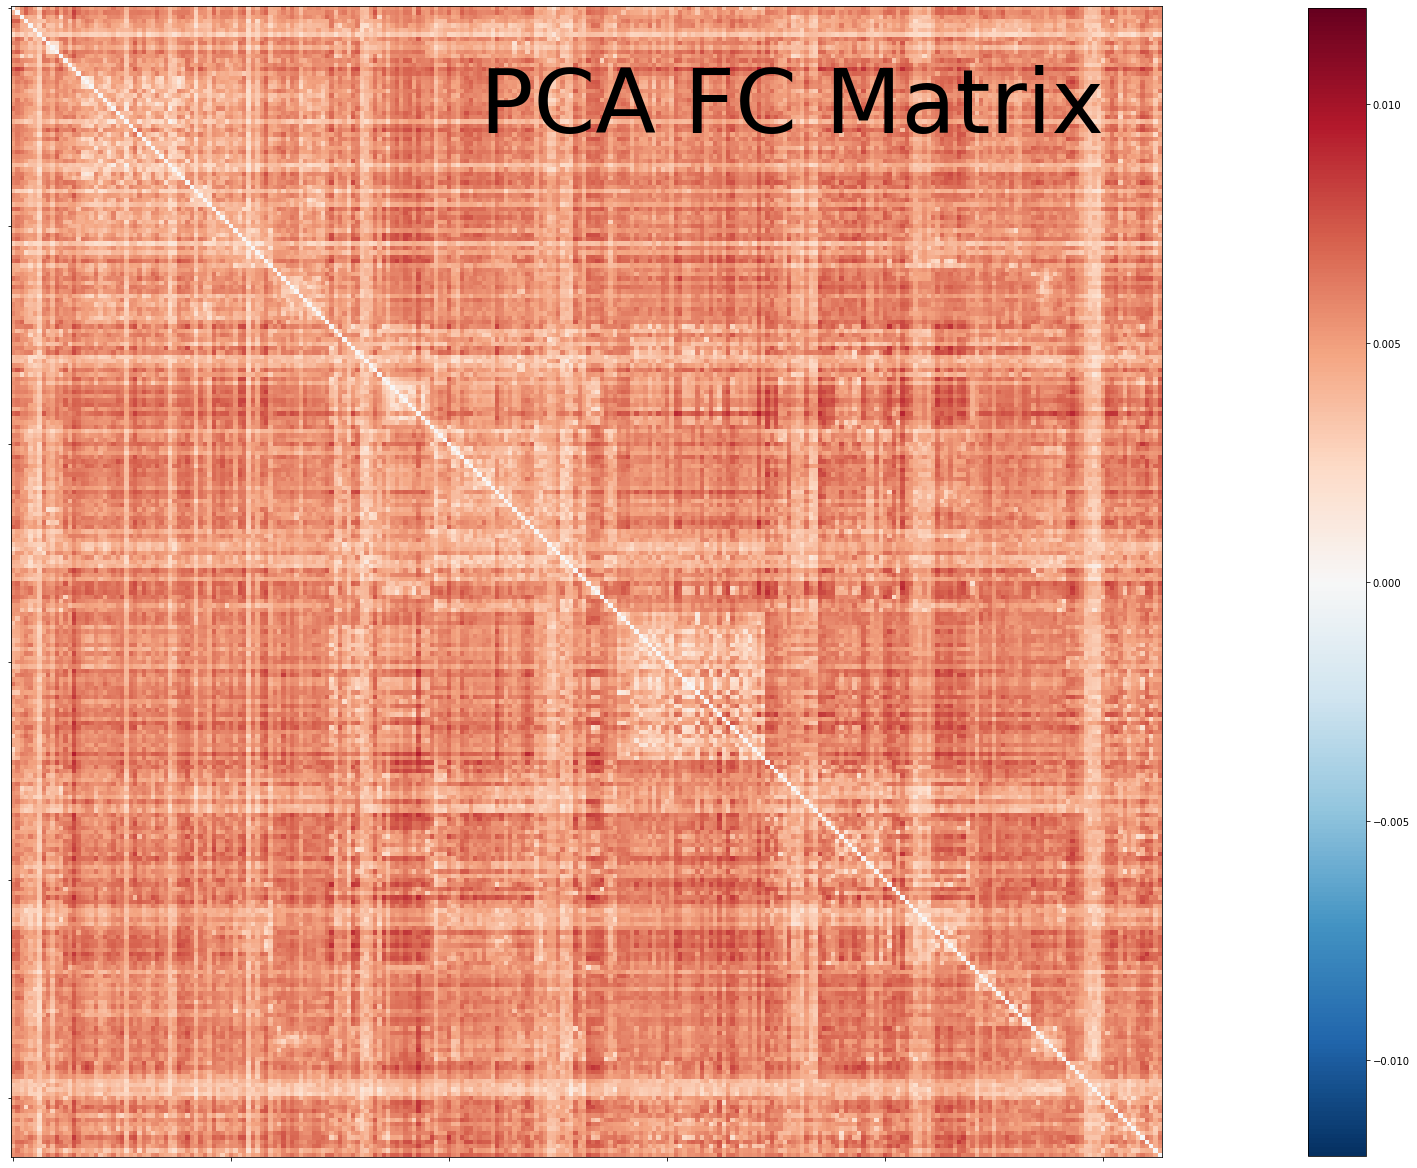

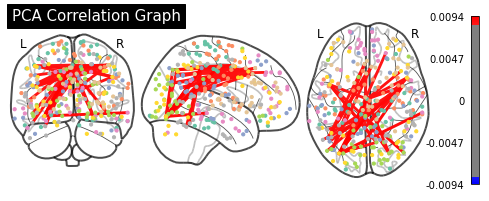

In [18]:
power = datasets.fetch_coords_power_2011()
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

fc_pca_scaled = fc_pca
plotting.plot_matrix(fc_pca_scaled, vmin=-0.012, vmax=0.012, colorbar=True, 
                     figure=(20, 20), title="PCA FC Matrix")
plotting.plot_connectome(fc_pca_scaled, coords, title='PCA Correlation Graph', 
                         edge_threshold='99.9%', node_size=10, colorbar=True)

### Independent Component Analysis

In [19]:
from sklearn.decomposition import FastICA

ica = FastICA(random_state=0)
ica.fit(fcs_trius)
fcs_trius_ica_reduced = ica.transform(fcs_trius)

print(ica.components_.shape)

(722, 34716)


In [20]:
# Reconstruct the FC but with the first ICA component.

first_ica_component = ica.components_[0]

fc_ica = np.zeros((264, 264))
fc_ica[np.triu_indices(fc_ica.shape[0], k=1)] = first_ica_component
fc_ica = fc_ica + fc_ica.T

print(fc_ica.shape)

(264, 264)


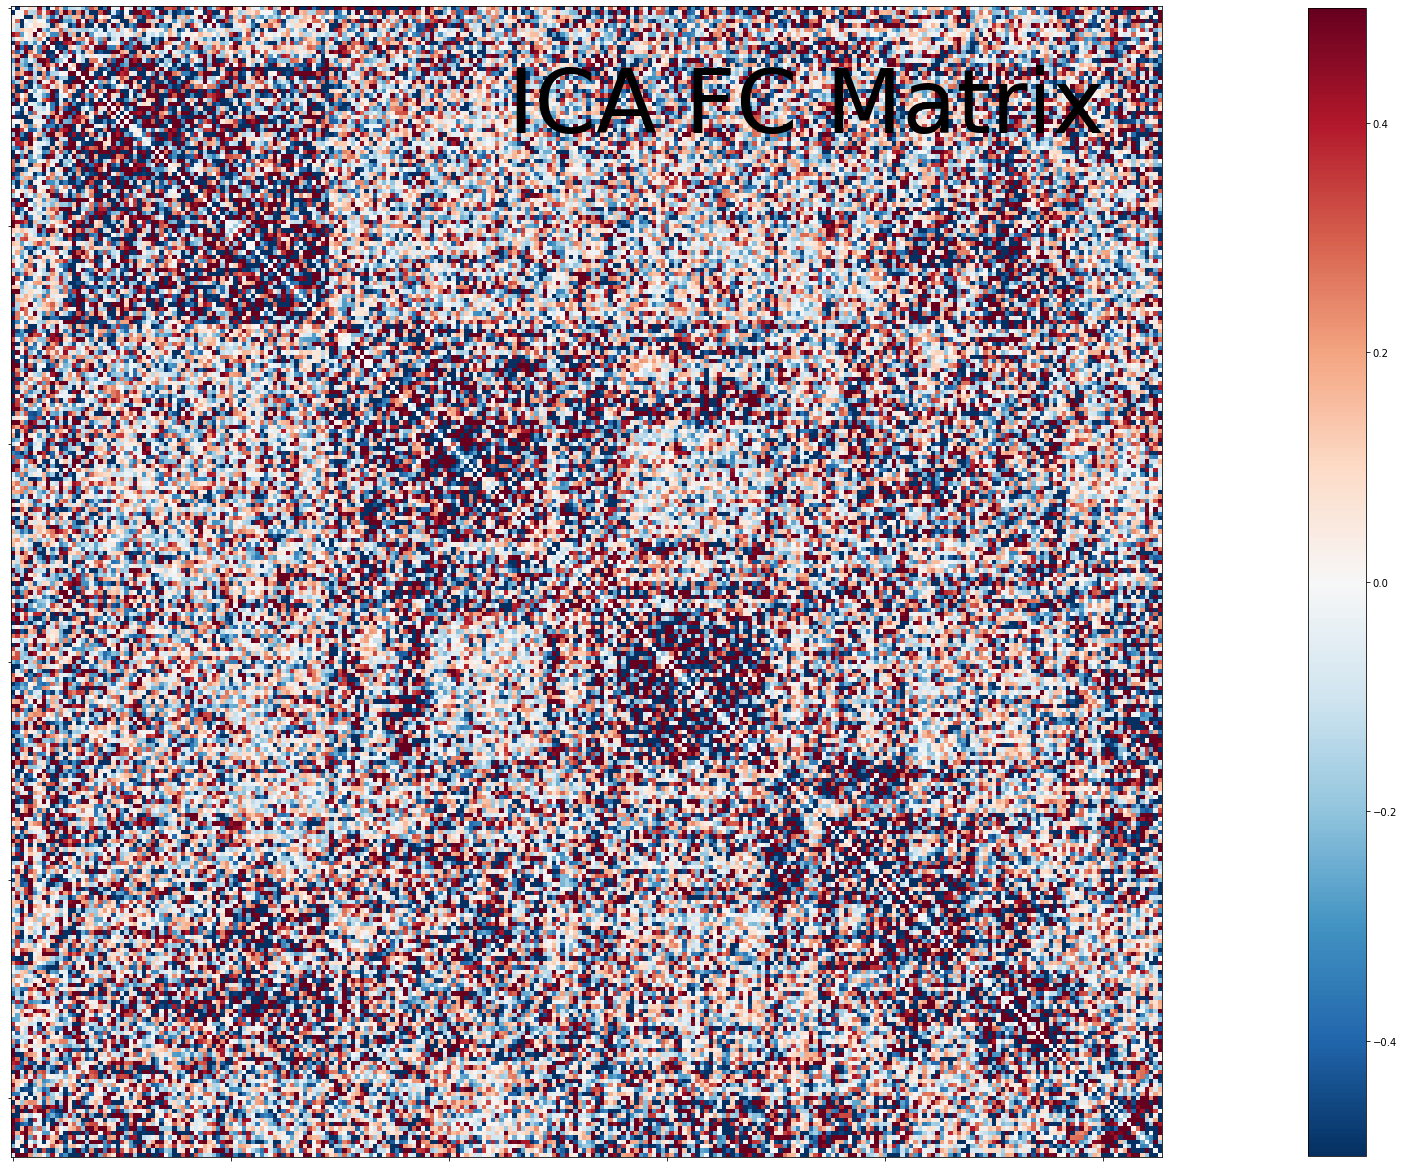

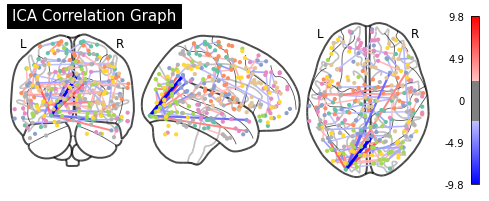

In [29]:
plotting.plot_matrix(fc_ica, vmin=-0.5, vmax=0.5, colorbar=True, 
                     figure=(20, 20), title="ICA FC Matrix")
plotting.plot_connectome(fc_ica, coords, title='ICA Correlation Graph', 
                         edge_threshold='99.7%', node_size=10, colorbar=True)

## Train and Analyze Clustering Models

### K-means

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(fcs_trius)
fcs_trius_km = kmeans.transform(fcs_trius)

print(fcs_trius_km.shape)
print(kmeans.labels_.shape)

(722, 3)
(722,)


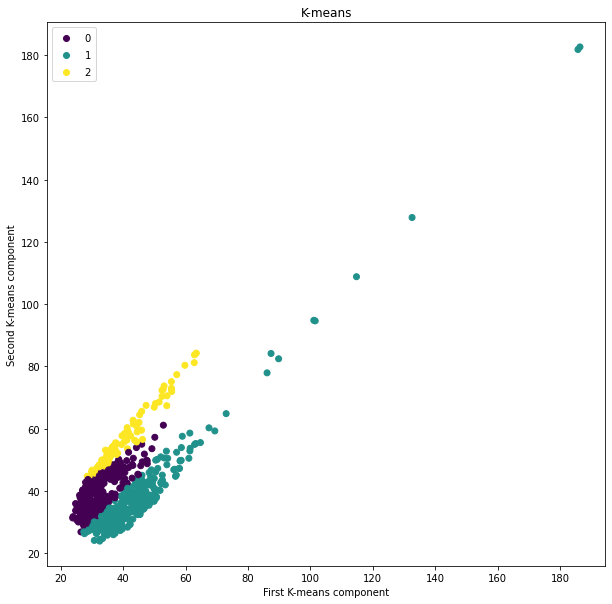

In [40]:
plt.figure(1, figsize=(10, 10))
scatter = plt.scatter(fcs_trius_km[:, 0], fcs_trius_km[:, 1], c=kmeans.labels_)
plt.title("K-means")
plt.legend(*scatter.legend_elements())
plt.xlabel("First K-means component")
plt.ylabel("Second K-means component")
plt.show()

### DBSCAN

In [44]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN()
dbscan.fit(fcs_trius)

print(dbscan.labels_.shape)

(722,)


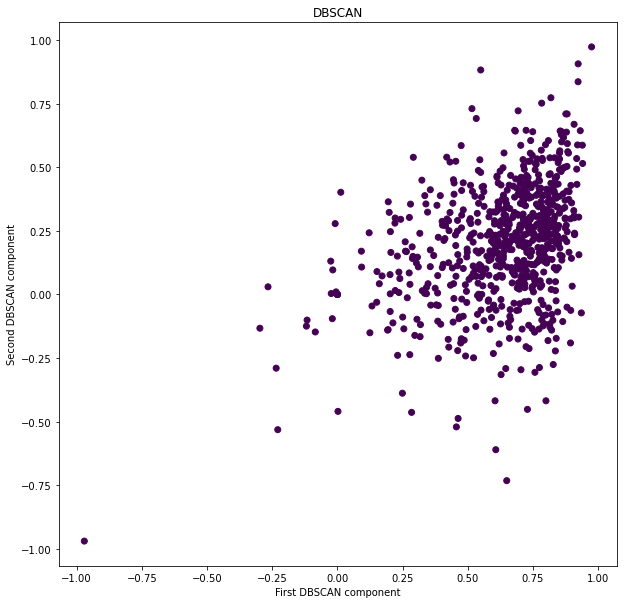

In [49]:
plt.figure(1, figsize=(10, 10))
plt.scatter(fcs_trius[:, 0], fcs_trius[:, 1], c=dbscan.labels_)
plt.title("DBSCAN")
plt.xlabel("First DBSCAN component")
plt.ylabel("Second DBSCAN component")
plt.show()

## Train and Analyze Manifold Model

### t-SNE

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
fcs_trius_tsne = tsne.fit_transform(fcs_trius)

print(fcs_trius_tsne.shape)

(722, 2)


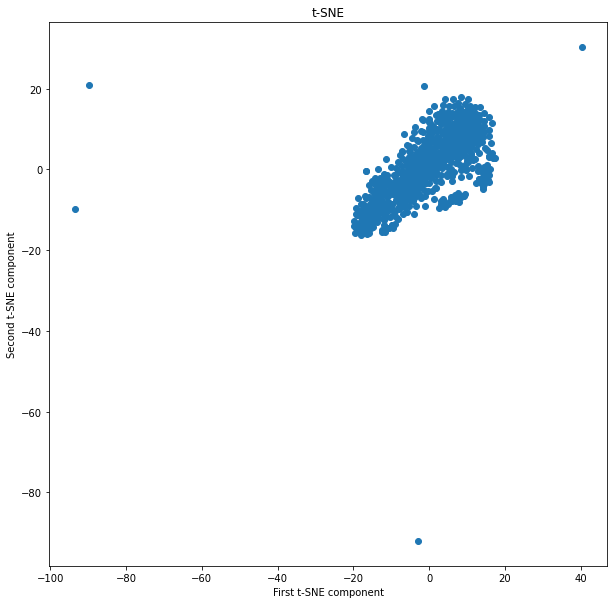

In [50]:
plt.figure(1, figsize=(10, 10))
plt.scatter(fcs_trius_tsne[:, 0], fcs_trius_tsne[:, 1])
plt.title("t-SNE")
plt.xlabel("First t-SNE component")
plt.ylabel("Second t-SNE component")
plt.show()